This notebook contains a basic overview of a multimodal workflow in current (master branch) scanpy

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl

# Reading in multimodal data is pretty easy

In [2]:
# !mkdir -p data
# !wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 -O data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5

In [3]:
DATAFILE = "data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"

In [4]:
pbmc = sc.read_10x_h5(DATAFILE, gex_only=False)
pbmc

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5527 × 33570 
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing and normalization

Split into protein and gene objects:

In [5]:
protein = pbmc[:, pbmc.var["genome"] == ""].copy()
genes = pbmc[:, pbmc.var["genome"] != ""].copy()

genes.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Protein

In [6]:
protein.var["control"] = protein.var_names.str.contains("control")

In [7]:
sc.pp.calculate_qc_metrics(
    protein,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    qc_vars=("control",),
    inplace=True,
)

 We can look at qc stuff:

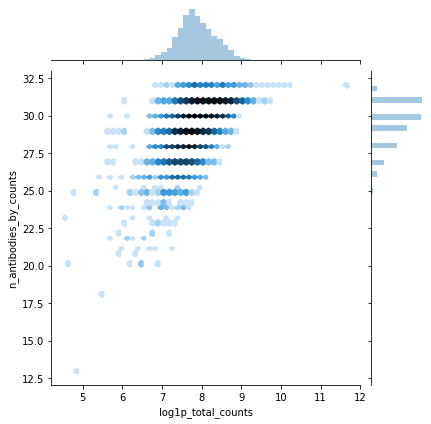

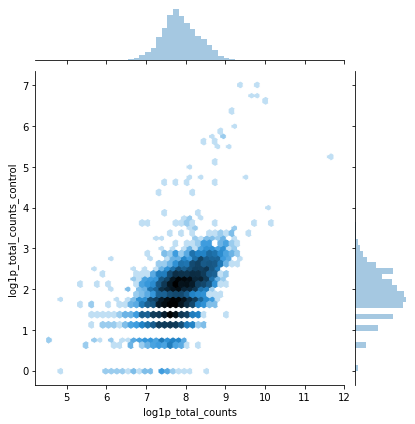

In [27]:
sns.jointplot("log1p_total_counts", "n_antibodies_by_counts", protein.obs, kind="hex", norm=mpl.colors.LogNorm())
sns.jointplot("log1p_total_counts", "log1p_total_counts_control", protein.obs, kind="hex", norm=mpl.colors.LogNorm())

In [9]:
protein.layers["counts"] = protein.X.copy()

In [10]:
sc.pp.normalize_geometric(protein)
sc.pp.log1p(protein)

In [12]:
sc.pp.pca(protein, n_comps=20)
sc.pp.neighbors(protein, use_rep="X", metric="cosine")  # There's only 32 antibodies, so might as well
sc.tl.umap(protein)
sc.tl.leiden(protein)

/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/isaac/github/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has be

... storing 'feature_types' as categorical
... storing 'genome' as categorical


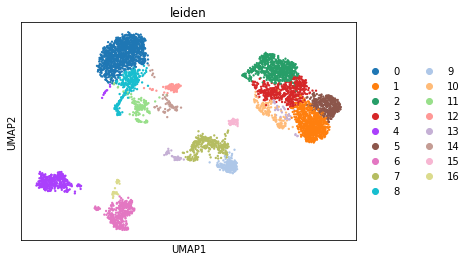

In [13]:
sc.pl.umap(protein, color="leiden")

In [14]:
protein

AnnData object with n_obs × n_vars = 5527 × 32 
    obs: 'n_antibodies_by_counts', 'log1p_n_antibodies_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_5_antibodies', 'pct_counts_in_top_10_antibodies', 'pct_counts_in_top_15_antibodies', 'total_counts_control', 'log1p_total_counts_control', 'pct_counts_control', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### RNA

Preprocess

In [15]:
genes.var["mito"] = genes.var_names.str.startswith("MT-")

In [16]:
sc.pp.filter_genes(genes, min_counts=1)
sc.pp.calculate_qc_metrics(genes, qc_vars=["mito"], inplace=True)

In [17]:
# Cache counts
genes.layers["counts"] = genes.X.copy()

In [18]:
sc.pp.normalize_total(genes)
sc.pp.log1p(genes)

In [19]:
sc.pp.pca(genes)
sc.pp.neighbors(genes, n_neighbors=30)
sc.tl.umap(genes)
sc.tl.leiden(genes)

/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/isaac/github/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has be

# Joining the data and doing some plotting

In [20]:
genes.obsm["protein"] = protein.to_df()
genes.obsm["protein_umap"] = protein.obsm["X_umap"]
genes.obs["protein_leiden"] = protein.obs["leiden"]

The clusterings disagree quite a bit, so we can tell that we are missing some information:

... storing 'feature_types' as categorical
... storing 'genome' as categorical


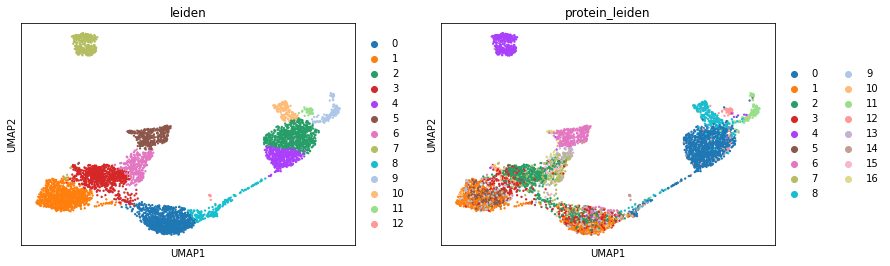

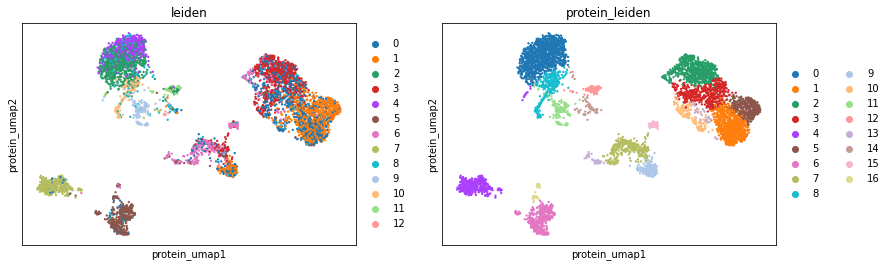

In [21]:
sc.pl.umap(genes, color=["leiden", "protein_leiden"])
sc.pl.embedding(genes, basis="protein_umap", color=["leiden", "protein_leiden"])

## Plotting values between modalities

* TODO: Get selectors like this working in scanpy.

# Integration ideas

## Joint clustering

So far I've only gotten okay results from this, but also haven't followed up on it much:

In [22]:
genes.obsp["protein_connectivities"] = protein.obsp["connectivities"]

In [23]:
sc.tl.leiden_multiplex(genes, ["connectivities", "protein_connectivities"])

As you can see, looks only okay. I think it'd be worth doing some feature selection as well as doublet removal and trying again.

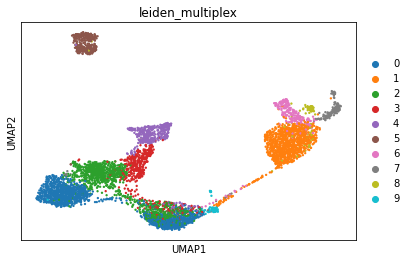

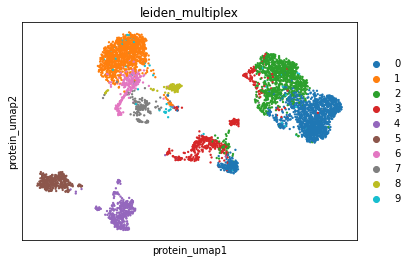

In [24]:
sc.pl.umap(genes, color="leiden_multiplex")
sc.pl.embedding(genes, basis="protein_umap", color="leiden_multiplex")

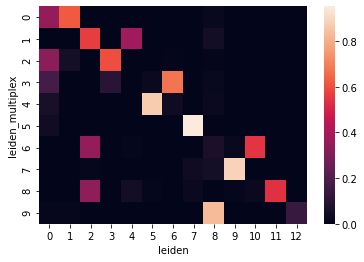

In [25]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["leiden"], normalize="index"))

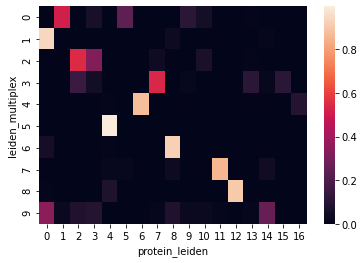

In [26]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["protein_leiden"], normalize="index"))